# Categorização de falhas dos equipmentos a partir das variáveis Físicas e Mecânicas do Equipamento.

OBS: O conjunto de dados em formato excel foi previamente codificado e organizado em um notebook anterior.

A intensão é de que este notebook contenha em sua maior parte, apenas os códigos pertinentes a construção do modelo XGBoost que irá categorizar as falha.


In [1]:
# Importação dos pacotes

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_excel('O_G_Equipment_Data.xlsx')
df.head(2)

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False


In [3]:
df.shape

(800, 10)

In [4]:
# Codificação da feature Fail 

labels = df['Fail'].astype('category').cat.categories.tolist()
replace_Fail = {'Fail': {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

print(replace_Fail)

{'Fail': {False: 1, True: 2}}


In [5]:
# Substituindo os valores tranformados.

df.replace(replace_Fail, inplace=True)

## **Machine Learning**

### A partir desse ponto será criado um modelo de Gradient Boost Tree, para verificar a possibilidade de categorizar, ordenar as falhas por "grau de intensidade"



## Separação do Treino e Teste 



In [6]:
data = df.copy()
data = data.drop(columns={'Cycle','Preset_1',	'Preset_2'})
data.head()

,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,1
1,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,1
2,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,1
3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,1
4,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,1


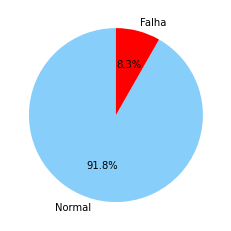

In [7]:
"""Esse código será a base para comparação com a proporção criada após separação
da base de teste e base de treino."""

df_t = pd.DataFrame(data.Fail.value_counts())

status = ['Normal', 'Falha']

df_t.insert(loc=1,column='status', value=status)

labels = df_t.status
colors = ['lightskyblue', 'red']
plt.pie(df_t['Fail'], labels= labels, colors=colors, startangle=90, autopct='%.1f%%')
plt.show()

In [8]:
"""Separação em TREINO e TESTE"""

seed = 173 # certifica que os dados serão divididos em com o label para teste e treino na mesma proporção.

from sklearn.model_selection import train_test_split

X = data.loc[:, data.columns != 'Fail']    # ENTRADA, Esse trecho de código remove a coluna a ser definida pelo modelo.
Y = data.Fail                              # SAÍDA


"""É nesse trecho de código que é feita a divisão da base de treino e  teste para se fazer a validação do modelo treinado,
e que posteriormente será salvo e dedicado em uma pasta específica para que esteja pronto para produção."""

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, 
                                                    random_state=seed) 

print('shape input de treino', X_train.shape)
print('shape input de teste', X_test.shape)
print('shape output de treino', Y_train.shape)
print('shape output de teste', Y_test.shape)

shape input de treino (640, 6)
shape input de teste (160, 6)
shape output de treino (640,)
shape output de teste (160,)


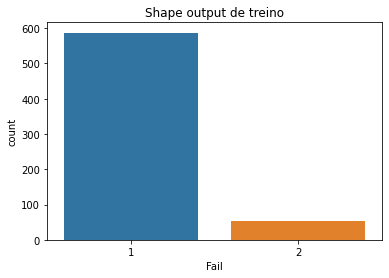

1    587
2     53
Name: Fail, dtype: int64

In [9]:
''' OBS: Verificando as proporções dos valores contido no atributo Fail, após a 
utilização de uma seed considerada ideal para criação do modelo de ML. '''

#TREINO

sns.countplot(x=Y_train)
plt.title("Shape output de treino")
plt.show()

Y_train.value_counts()

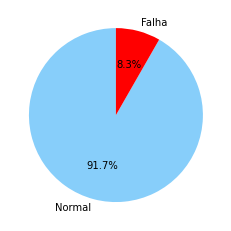

In [10]:
"""Verificando se a seed utilizada na separação da base de treino e teste está
na proporção ideal para o modelo"""

df_train = pd.DataFrame(Y_train.value_counts())

status = ['Normal', 'Falha']

df_train.insert(loc=1,column='status', value=status)

labels = df_train.status
colors = ['lightskyblue', 'red']
plt.pie(df_train['Fail'], labels= labels, colors=colors, startangle=90, autopct='%.1f%%')
plt.show()

#### É possível verificar enque a proporção do atributo Fail está bastante similar ao conjunto original de dados, o que nos garante uma boa margem de acurácia durante a criação do modelo classificador.

O mesmos será feito para a base de teste.

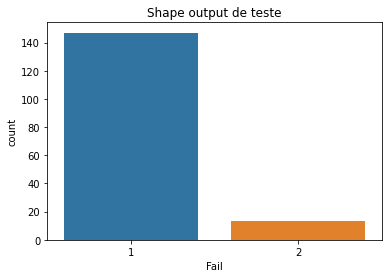

1    147
2     13
Name: Fail, dtype: int64

In [11]:
# TESTE

sns.countplot(x=Y_test)
plt.title("Shape output de teste")
plt.show()

Y_test.value_counts()

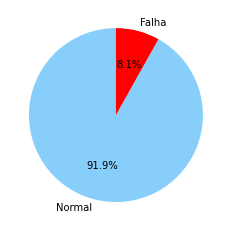

In [12]:
df_test = pd.DataFrame(Y_test.value_counts())

status = ['Normal', 'Falha']

df_test.insert(loc=1,column='status', value=status)

labels = df_test.status
colors = ['lightskyblue', 'red']
plt.pie(df_test['Fail'], labels= labels, colors=colors, startangle=90, autopct='%.1f%%')
plt.show()

## <font color = red> GRADIENT BOOST TREE

In [13]:
''' Importando as bibliotecas necessárias para criação do modelo de ML'''

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [14]:
'''Construindo o modelo de ML com a função do SKLearn.

Todas a modificações e aprimorações no modelo desem ser feitas nesse trecho
de código, utilizando a biblioteca referente para aprimorar as métricas
do modelo. '''

regressor = GradientBoostingRegressor(
    max_depth=2,       # referente ao número de "folhas" por árvore.
    n_estimators=2,    # referente ao quantidade de árvores por conjunto
    learning_rate=1.0  # hiperparametriza (escolhe os mehores valores) em um range determinado.
)
regressor.fit(X_train, Y_train)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=2)

In [15]:
''' Esse código irá medir a validação de cada erro (média quadrática do erro) encontrado 
durante a construção do modelo e a partir dessa medição encontrar o número ótimo de árvores 
para que o modelo esteja o mais preciso possível.'''

errors = [mean_squared_error(Y_test, Y_pred) for Y_pred in regressor.staged_predict(X_test)]
best_n_estimators = np.argmin(errors)

In [16]:
# Modelo sendo reconstruindo com os melhores valores selecionados após os erros serem "corrigidos".

best_regressor = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=best_n_estimators,
    learning_rate=1.0
)
best_regressor.fit(X_train, Y_train)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=1)

In [17]:
'''Verificando a média absoluta de erros que o modelo gerou ao tentar classificar
os labels definidos'''

Y_pred = best_regressor.predict(X_test)
mean_absolute_error(Y_test, Y_pred)

0.12178592064714959

### NORMALIZAÇÃO

In [18]:
'''Utilizando uma das técnicas de normalização para proporcionar uma otimização
extra no modelo criado.'''

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
# Verificando o quanto de melhora foi gerada após a normalização.

Y_pred = best_regressor.predict(X_test)
mean_absolute_error(Y_test, Y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"


0.09189618644067812

In [20]:
import pickle
pickle.dump(best_regressor, open('model_GBT.sav', 'wb'))